In [1]:
from nilearn import datasets, image, plotting
import numpy as np
import nibabel as nib

julich_ontology_l = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'julich_ontology_l.xml',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.xml',
            {'move': 'julich_ontology_l.xml'}
        )
    ]
)[0]

julich_ontology_r = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'julich_ontology_r.xml',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.xml',
            {'move': 'julich_ontology_r.xml'}
        )
    ]
)[0]

ontology = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'jubrain-ontology_22.json',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/jubrain-ontology_22.json',
            {'move': 'jubrain-ontology_22.json'}
        )
    ]
)[0]

def parse_region(elem, id_2_num, father=None, triples=[]):
    name = elem['name']
    if 'labelIndex' in elem:
        if elem['labelIndex'] is not None:
            index = int(elem['labelIndex'])
            if index in id_2_num:
                num = id_2_num[index]
                triples.append((name, num))
            else:
                print(f'Este no esta: {index, name}')
        
    for c in elem['children']:
        parse_region(c, id_2_num, father=name, triples=triples)
        
    return triples


import json
import pandas as pd
import xml.etree.ElementTree as ET

tree = ET.parse(julich_ontology_l)

id_2_num = {}
for a in tree.iter():
    if a.tag == 'Structure':
        num = int(a.attrib['grayvalue'])
        id_ = int(a.attrib['id'])
        id_2_num[id_] = num

tree = ET.parse(julich_ontology_r)

for a in tree.iter():
    if a.tag == 'Structure':
        num = int(a.attrib['grayvalue'])
        id_ = int(a.attrib['id'])
        id_2_num[id_] = num


with open(ontology) as f:
    data = json.load(f)

regions = data['properties']['regions']
for elem in regions:
    triples = parse_region(elem, id_2_num)
    
    for n, r in [
        (13, 'GapMap Frontal-I (GapMap)'),
        (32, 'GapMap Frontal-to-Occipital (GapMap)'),
        (59, 'GapMap Temporal-to-Parietal (GapMap)'),
        (89, 'GapMap Frontal-II (GapMap)'),
        (95, 'GapMap Frontal-to-Temporal (GapMap)')
    ]:
        triples.append((r, n))
        
    f.close()   
    regions = pd.DataFrame(triples, columns=['r_name', 'r_number']).astype({'r_number': 'int32'}).sort_values('r_number')
    regions.drop_duplicates(inplace=True)
    

Este no esta: (237, 'IF (Amygdala)')


In [2]:
regions2 = regions.copy()
regions2['r_number'] = regions2['r_number'] + 1000
regions2['hemis'] = 'l'
regions['hemis'] = 'r'

regions = pd.concat((regions, regions2))

In [3]:
regions[regions.r_name.str.contains('IFG')]

,r_name,r_number,hemis
49,Area 44 (IFG),64,r
50,Area 45 (IFG),67,r
49,Area 44 (IFG),1064,l
50,Area 45 (IFG),1067,l


In [4]:
analized_region_number = 1067
analized_region_name = 'Area 45 (IFG)'

In [5]:
wb22_l = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich'),
    [
        (
            'wb22_l.nii.gz',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.nii.gz',
            {'move': 'wb22_l.nii.gz'}
        )
    ]
)[0]

wb22_r = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich'),
    [
        (
            'wb22_r.nii.gz',
            'https://github.com/NeuroLang/neurolang_data/raw/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz',
            {'move': 'wb22_r.nii.gz'}
        )
    ]
)[0]

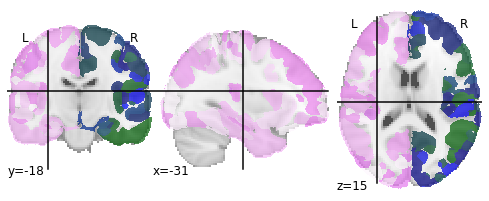

In [6]:
img_r = image.load_img(wb22_r)
img_l = image.load_img(wb22_l)
img_l_data = img_l.get_fdata()
img_r_data = img_r.get_fdata()
img_l_unmaskes = np.nonzero(img_l_data)

for v in zip(*img_l_unmaskes):
    value = img_l_data[v[0]][v[1]][v[2]]
    ex_value = img_r_data[v[0]][v[1]][v[2]]
    if ex_value == 0:
        img_r_data[v[0]][v[1]][v[2]] = value + 1000
    
conc_img = nib.spatialimages.SpatialImage(img_r_data, img_r.affine)
plotting.plot_roi(conc_img)

In [7]:
mni_t1 = nib.load(datasets.fetch_icbm152_2009()['t1'])
mni_t1_4mm = image.resample_img(mni_t1, np.eye(3) * 1)

conc_img = image.resample_img(
    conc_img, mni_t1_4mm.affine, interpolation='nearest'
)

conc_img_data = conc_img.get_fdata()
conc_img_unmaskes = np.nonzero(conc_img_data)

julich_brain = []
for v in zip(*conc_img_unmaskes):
    julich_brain.append((v[0], v[1], v[2], conc_img_data[v[0]][v[1]][v[2]]))

In [8]:
d = conc_img.get_fdata()
mask = d != analized_region_number
d[mask] = 0
#d[193//2:] = 0
wb = nib.spatialimages.SpatialImage(d, conc_img.affine)

In [9]:
d.shape

(195, 231, 187)

In [10]:
mask = wb.get_fdata() > 0
labels = wb.get_fdata()[mask]
len(labels)

3859

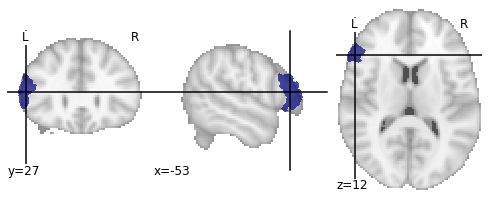

In [11]:
from scipy.ndimage import binary_dilation
import nibabel as nib

new_img = nib.spatialimages.SpatialImage(
    binary_dilation(wb.get_fdata()), 
    wb.affine
)

plotting.plot_roi(new_img)

In [12]:
import numpy as np

jl_data = new_img.get_fdata()
jl_unmaskes = np.nonzero(jl_data)

xyz_to_jl_region = []
for v in zip(*jl_unmaskes):
    xyz_to_jl_region.append(tuple(v))

In [13]:
from neurolang.frontend import NeurolangPDL

nl = NeurolangPDL()

j_brain = nl.add_tuple_set(
    julich_brain,
    name='julich_brain'
)

j_regions = nl.add_tuple_set(
    regions.values,
    name='julich_regions'
)

dilated_ifg44 = nl.add_tuple_set(
    tuple(xyz_to_jl_region),
    name='dilated_ifg44'
)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [23]:
 with nl.scope as e:

    e.local_areas[e.area, e.id] = (
        e.julich_brain[e.i, e.j, e.k, e.id] &
        e.dilated_ifg44[e.i, e.j, e.k,] &
        e.julich_regions[e.area, e.id, e.hemis]
    )
    
    res = nl.solve_all()
    local_areas = res['local_areas'].as_pandas_dataframe()

In [24]:
for v in zip(*img_l_unmaskes):
    value = img_l_data[v[0]][v[1]][v[2]]
    ex_value = img_r_data[v[0]][v[1]][v[2]]
    if ex_value == 0:
        img_r_data[v[0]][v[1]][v[2]] = value + 1000
    
conc_img = nib.spatialimages.SpatialImage(img_r_data, img_r.affine)

mask = conc_img.get_fdata() > 0
labels = np.unique(conc_img.get_fdata()[mask])
print(len(labels))

248


In [25]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

masker = NiftiLabelsMasker(labels_img=conc_img, standardize=True)
connectome_measure = ConnectivityMeasure(kind='correlation')

data = datasets.fetch_development_fmri(n_subjects=1)
#data = datasets.fetch_development_fmri(n_subjects=140, reduce_confounds=False)
#data = datasets.fetch_adhd(n_subjects=15)



time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)[0]


import numpy as np
np.fill_diagonal(correlation_matrices, 0)

In [26]:
if analized_region_number > 1000:
    ar = 124 + analized_region_number - 1001
else:
    ar = analized_region_number - 1

for n, r in enumerate(regions.r_name.values):
    if n == ar:
        print(r)
        print(analized_region_name)

Area 45 (IFG)
Area 45 (IFG)


In [27]:
regions[regions.r_name == analized_region_name]

,r_name,r_number,hemis
50,Area 45 (IFG),67,r
50,Area 45 (IFG),1067,l


In [28]:
area_44_con = correlation_matrices[ar]

In [29]:
regions['r_name'] = regions.r_name.apply(lambda x: x.replace('.', ''))

In [30]:
corr44 = pd.DataFrame(zip(area_44_con, regions.r_name.values, regions.r_number.values), columns=['corr', 'r_name', 'r_number'])


In [31]:
corr44[corr44['corr'] >= corr44['corr'].quantile(.95)].sort_values('corr', ascending=False)

,corr,r_name,r_number
45,0.291118,Area 33 (ACC),46
21,0.275860,Area PGp (IPL),22
240,0.272940,Area Fo2 (OFC),1117
25,0.268458,Area p24ab (pACC),26
67,0.267809,Area Id1 (Insula),68
29,0.263765,Area TE 3 (STG),30
153,0.263564,Area TE 3 (STG),1030
52,0.258333,Area Id2 (Insula),53
177,0.252226,CA1 (Hippocampus),1054
236,0.248165,Area PFop (IPL),1113


In [32]:
for l in local_areas['area'].unique():
    corr44 = corr44[corr44.r_name != l]

In [33]:
long_regions = corr44[corr44['corr'] >= corr44['corr'].quantile(.95)].sort_values('corr', ascending=False)

In [34]:
long_regions = long_regions[['r_name', 'r_number']]
long_regions = long_regions.append(regions[regions.r_number == analized_region_number])

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [35]:
long_regions

,hemis,r_name,r_number
45,NaN,Area 33 (ACC),46
21,NaN,Area PGp (IPL),22
240,NaN,Area Fo2 (OFC),1117
25,NaN,Area p24ab (pACC),26
67,NaN,Area Id1 (Insula),68
29,NaN,Area TE 3 (STG),30
153,NaN,Area TE 3 (STG),1030
52,NaN,Area Id2 (Insula),53
177,NaN,CA1 (Hippocampus),1054
236,NaN,Area PFop (IPL),1113


In [36]:
long_regions = long_regions[['r_name','r_number']]

long_areas = nl.add_tuple_set(
    long_regions.values,
    name='long_areas'
)

In [37]:
long_regions.head(20)

,r_name,r_number
45,Area 33 (ACC),46
21,Area PGp (IPL),22
240,Area Fo2 (OFC),1117
25,Area p24ab (pACC),26
67,Area Id1 (Insula),68
29,Area TE 3 (STG),30
153,Area TE 3 (STG),1030
52,Area Id2 (Insula),53
177,CA1 (Hippocampus),1054
236,Area PFop (IPL),1113


In [38]:
ns_database_fn, ns_features_fn = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('neurosynth'),
    [
        (
            'database.txt',
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        ),
        (
            'features.txt',
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        ),
    ]
)

ns_database = pd.read_csv(ns_database_fn, sep=f'\t')
ijk_positions = (
    np.round(nib.affines.apply_affine(
        np.linalg.inv(mni_t1_4mm.affine),
        ns_database[['x', 'y', 'z']].values.astype(float)
    )).astype(int)
)
ns_database['i'] = ijk_positions[:, 0]
ns_database['j'] = ijk_positions[:, 1]
ns_database['k'] = ijk_positions[:, 2]

ns_features = pd.read_csv(ns_features_fn, sep=f'\t')
ns_docs = ns_features[['pmid']].drop_duplicates()
ns_terms = (
    pd.melt(
            ns_features,
            var_name='term', id_vars='pmid', value_name='TfIdf'
       )
    .query('TfIdf > 1e-3')[['pmid', 'term']]
)

activations = nl.add_tuple_set(ns_database.values, name='activations')
terms = nl.add_tuple_set(ns_terms.values, name='terms')
docs = nl.add_uniform_probabilistic_choice_over_set(
        ns_docs.values, name='docs'
)

from rdflib import RDFS

part_of = nl.new_symbol(name='http://www.obofoundry.org/ro/ro.owl#part_of')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
label = nl.new_symbol(name=str(RDFS.label))
hasTopConcept = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#hasTopConcept')

In [39]:
from typing import Iterable

@nl.add_symbol
def word_lower(name: str) -> str:
    return name.lower()

@nl.add_symbol
def word_lower_contains(s1: str, s2: str) -> bool:
    return s1.lower() in s2.lower()

In [ ]:
with nl.scope as e:

    e.long_regions[e.d, e.id] = (
        e.long_areas[e.area, e.id] &
        e.julich_brain[e.i, e.j, e.k, e.id] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    e.long_network[e.d, e.id] = (
        e.long_regions[e.d, analized_region_number] &
        e.long_regions[e.d, e.id] &
        (e.id != analized_region_number)
    )
    
    e.local_regions[e.d, e.id] = (
        e.dilated_ifg44[e.i, e.j, e.k,] &
        e.julich_regions[e.area, e.id] &
        e.julich_brain[e.i, e.j, e.k, e.id] &
        e.activations[
            e.d, ..., ..., ..., ..., 'MNI', ..., ..., ..., ...,
            ..., ..., ..., e.i, e.j, e.k
        ]
    )
    
    e.local_network[e.d, e.id] = (
        e.local_regions[e.d, e.id] &
        e.local_regions[e.d, analized_region_number] &
        (e.id != analized_region_number)
    )
    
    e.result[e.t, e.PROB[e.t]] = (
       (e.terms[e.d, e.t] ) // 
        (e.local_network[e.d, e.id] & e.docs[e.d] & (~e.long_network[e.d, e.id2]))  
    )

    
    res_long = nl.solve_all()
